# Problem : Cluster the diamonds as per their properties

Data link : https://www.kaggle.com/shivam2503/diamonds

# Data Description

price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

# Load the Data

In [ ]:
import pandas as pd
data = pd.read_csv("/content/diamonds.csv")

In [ ]:
data.shape

(53940, 11)

In [ ]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
cat_columns = data.select_dtypes(include = "object").columns
cat_columns

Index(['cut', 'color', 'clarity'], dtype='object')

In [ ]:
num_columns = data.select_dtypes(exclude = "object").columns
num_columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.3, random_state=7)#,stratify=None)

In [ ]:
X_train.shape, X_test.shape

((37758, 11), (16182, 11))

# Preprocess

## Check missing values

In [ ]:
X_train.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [ ]:
X_test.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

## Handle String Columns

Here all categorical columns are ordinal so use label encoding for all categorical columns

In [ ]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
d = defaultdict(LabelEncoder)
# Encoding the variable
X_train.loc[:,cat_columns] = X_train.loc[:,cat_columns].apply(lambda x: d[x.name].fit_transform(x))

# Using the dictionary to label future data
X_test.loc[:,cat_columns] = X_test.loc[:,cat_columns].apply(lambda x: d[x.name].transform(x))

In [ ]:
X_train.head() # Encoded Data

,carat,cut,color,clarity,depth,table,price,x,y,z
28336,0.33,3,3,4,61.9,59.0,666,4.43,4.45,2.75
8436,1.03,2,3,3,62.1,56.0,4407,6.44,6.48,4.01
42937,0.36,3,1,3,61.5,58.0,505,4.56,4.61,2.82
17975,1.05,2,3,4,62.2,53.0,7270,6.51,6.55,4.06
38939,0.40,3,1,4,60.3,58.0,1053,4.80,4.82,2.90


**** This is extra step for your information of how to convert the encoded data back to original form

In [ ]:
# Inverse the encoded
X_train.head().loc[:,cat_columns].apply(lambda x: d[x.name].inverse_transform(x))

,cut,color,clarity
28336,Premium,G,VS1
8436,Ideal,G,SI2
42937,Premium,E,SI2
17975,Ideal,G,VS1
38939,Premium,E,VS1


# Normalize the Numeric Columns ONLY

## Robust Scalar

value = (value – median) / (p75 – p25) # IQR --> Q3-Q1 

## Standard Scalar

value = (value - mean) / std_dev

In [ ]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler().fit(X_train.loc[:,num_columns])
X_train.loc[:,num_columns] = rs.transform(X_train.loc[:,num_columns])
X_test.loc[:,num_columns] = rs.transform(X_test.loc[:,num_columns])

In [ ]:
X_train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
28336,-0.578125,3,3,4,0.066667,0.666667,-0.401613,-0.697802,-0.700000,-0.687500
8436,0.515625,2,3,3,0.200000,-0.333333,0.460369,0.406593,0.427778,0.437500
42937,-0.531250,3,1,3,-0.200000,0.333333,-0.438710,-0.626374,-0.611111,-0.625000
17975,0.546875,2,3,4,0.266667,-1.333333,1.120046,0.445055,0.466667,0.482143
38939,-0.468750,3,1,4,-1.000000,0.333333,-0.312442,-0.494505,-0.494444,-0.553571


In [ ]:
X_train.dtypes

carat      float64
cut          int64
color        int64
clarity      int64
depth      float64
table      float64
price      float64
x          float64
y          float64
z          float64
dtype: object

# Apply Agglomerative Clustering ( Hierarchical)

## Advantage 

1. Used for descriptive clustering analysis means after finding clusters we can describe which point comes under which cluster 

2. Step by step formation of clusters


## Limitation

1. Algorithm requires O(n^2) RAM and O (n^3) time 

It doesn't work on Large data

So, sample the data and apply the algorithm



2. This clustering can't be applied to predict on new data (test data) . It doesn't have predict method because of its approach.

In [ ]:
n_sample = 1000

In [ ]:
X_train_sample = X_train.sample(n_sample,random_state=None)

In [ ]:
X_test_sample = X_test.sample(n_sample,random_state=None)

## Get the number of clusters using dendrogram

Use ONLY 5K random rows because colab will fail for complete data

We can see the longest vertical lines without any horizontal lines are with 3 clusters

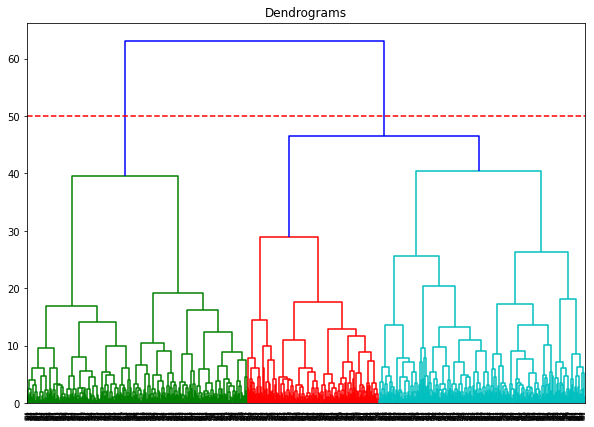

In [ ]:
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_train_sample, method='ward'))
plt.axhline(y=50, color='r', linestyle='--')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster_labels = cluster.fit_predict(X_train_sample)

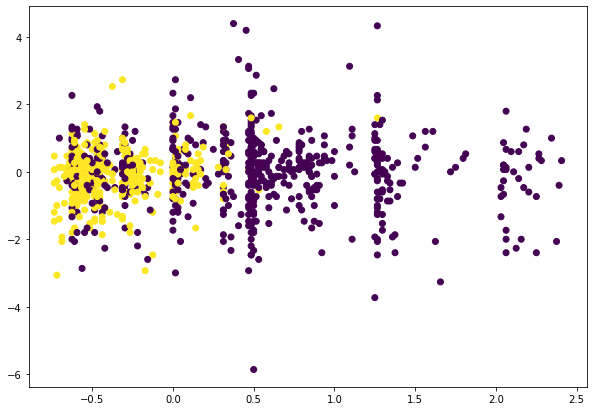

In [ ]:
plt.figure(figsize=(10, 7))  
plt.scatter(X_train_sample['carat'], X_train_sample['depth'], c=cluster.labels_) 

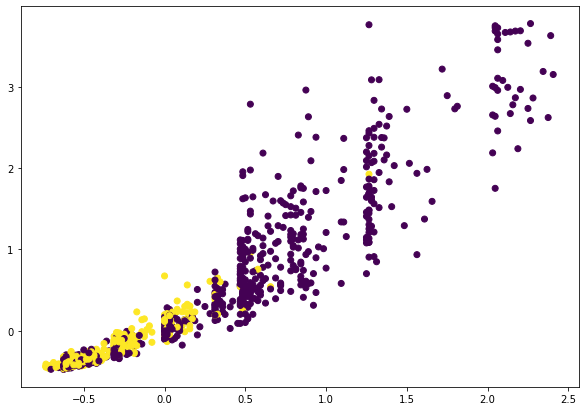

In [ ]:
plt.figure(figsize=(10, 7))  
plt.scatter(X_train_sample['carat'], X_train_sample['price'], c=cluster.labels_) 

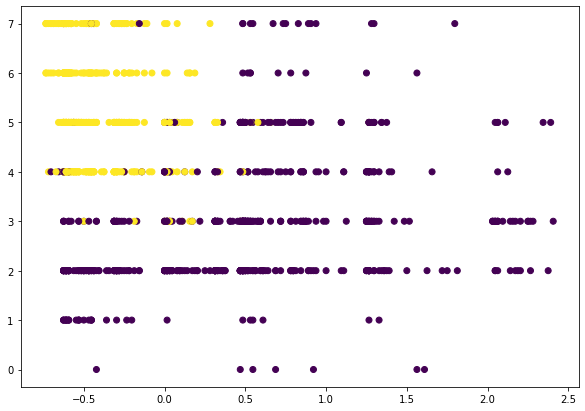

In [ ]:
plt.figure(figsize=(10, 7))  
plt.scatter(X_train_sample['carat'], X_train_sample['clarity'], c=cluster.labels_) 

# K-means Clustering

## Advantage 

1. Simple clustering mechanism

2. Has different types like k-median, k-medoid, etc

3. Can be used to predict clusters for new data ( test data )

## Dis Advantage

1. Cannot point out outliers

2. Finding right k ( number of clusters ) is tedious task

In [ ]:
X_train.shape, X_test.shape

((37758, 11), (16182, 11))

## Simple K means with K =3 ( random choice of K)

### Fit on Training data

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
K =3

In [ ]:
kmeanModel = KMeans(n_clusters=K, random_state =7)
# max_iter --> maximum iteratoin
# tol --> tolerance (how much error is allowed?) for convergence

In [ ]:
kmeanModel.fit(X_train)

KMeans(n_clusters=3, random_state=7)

In [ ]:
kmeanModel.get_params

<bound method BaseEstimator.get_params of KMeans(n_clusters=3, random_state=7)>

In [ ]:
kmeanModel.cluster_centers_

array([[ 4.49528215e+04, -2.81446010e-01,  2.50162763e+00,
         2.30789996e+00,  3.98650258e+00, -6.61373561e-02,
         8.00661638e-02, -1.98134235e-01, -3.21378621e-01,
        -3.28735830e-01, -3.22618811e-01],
       [ 8.93485948e+03,  3.60900782e-01,  2.56883138e+00,
         2.73197841e+00,  3.42989838e+00,  2.44204509e-02,
         2.60969091e-01,  4.17058173e-01,  2.58871646e-01,
         2.56005875e-01,  2.62194206e-01],
       [ 2.69649846e+04,  3.79857713e-01,  2.58916209e+00,
         2.71600223e+00,  4.08570064e+00, -6.32556166e-02,
         1.11405533e-01,  8.37490241e-01,  1.14379016e-01,
         1.14196794e-01,  1.10892047e-01]])

In [ ]:
kmeanModel.labels_[:5]

array([2, 1, 0, 2, 0], dtype=int32)

### Predict on Test Data

In [ ]:
predictions = kmeanModel.predict(X_test)

In [ ]:
predictions[:5]

array([0, 1, 1, 2, 2], dtype=int32)

### Find K using L-bow Method

Plot inertia or distortions (Y-axis) graph for various K values ( X - axis).

inertia =
Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

distortions = avg distances of samples to their closest cluster center

K value where there is L-bow in that graph should be selected 

### Limitation ::

This method subjective and may not work for all datasets. If no L bow then will have to try K values randomly

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state =7)
    kmeanModel.fit(X_train)
 
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 3.158351035664309
2 : 2.762184056658353
3 : 2.484245906612965
4 : 2.35580624214235
5 : 2.231976191802
6 : 2.156305279406165
7 : 2.108478477267194
8 : 2.0547068893363987
9 : 2.001835297054679


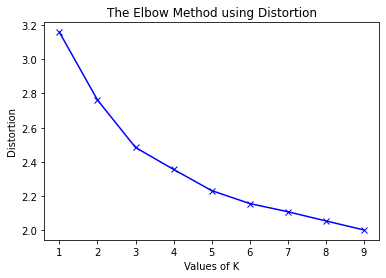

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 414064.91664868395
2 : 323703.00628952426
3 : 261785.31877432624
4 : 234324.33866288772
5 : 211850.65001009702
6 : 198740.62422591983
7 : 187849.82614897366
8 : 179697.08680656072
9 : 171200.09240540545


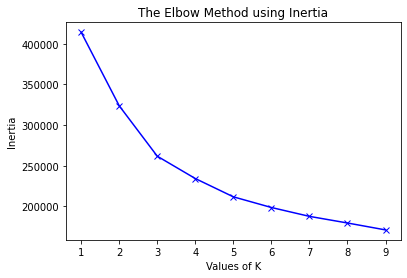

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()